In [97]:
from sklearn.feature_extraction.text import CountVectorizer

import beautifultools as bt
import pandas as pd
import wordcloud as wc
import pickle
import qgrid
import os.path

# Webpage Scraping for Scouting
## Ampliare la reliability del modello attraverso topic modeling

**Preambolo:** Utilizzare l'informazione contenuta nelle pagine iniziali di clienti Siemens e di potenziali prospect Siemens per allenare un algoritmo che dato in input una serie di parole chiave del sito target riporti la probabilità di conversione $[0,1]$ 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Webpage-Scraping-for-Scouting" data-toc-modified-id="Webpage-Scraping-for-Scouting-1">Webpage Scraping for Scouting</a></span><ul class="toc-item"><li><span><a href="#Ampliare-la-reliability-del-modello-attraverso-topic-modeling" data-toc-modified-id="Ampliare-la-reliability-del-modello-attraverso-topic-modeling-1.1">Ampliare la reliability del modello attraverso topic modeling</a></span></li><li><span><a href="#Caricamento-dei-dati" data-toc-modified-id="Caricamento-dei-dati-1.2">Caricamento dei dati</a></span></li><li><span><a href="#Analisi" data-toc-modified-id="Analisi-1.3">Analisi</a></span><ul class="toc-item"><li><span><a href="#La-distribuzione-delle-parole-chiave-per-cliente-e-prospect" data-toc-modified-id="La-distribuzione-delle-parole-chiave-per-cliente-e-prospect-1.3.1">La distribuzione delle parole chiave per cliente e prospect</a></span></li><li><span><a href="#La-situazione-alle-code-della-distribuzione-e-nel-suo-centro" data-toc-modified-id="La-situazione-alle-code-della-distribuzione-e-nel-suo-centro-1.3.2">La situazione alle code della distribuzione e nel suo centro</a></span></li><li><span><a href="#Stemming" data-toc-modified-id="Stemming-1.3.3">Stemming</a></span></li></ul></li><li><span><a href="#Modellazione" data-toc-modified-id="Modellazione-1.4">Modellazione</a></span><ul class="toc-item"><li><span><a href="#Step-1" data-toc-modified-id="Step-1-1.4.1">Step 1</a></span></li><li><span><a href="#Step-2" data-toc-modified-id="Step-2-1.4.2">Step 2</a></span></li><li><span><a href="#Step-3" data-toc-modified-id="Step-3-1.4.3">Step 3</a></span></li></ul></li><li><span><a href="#Conclusioni" data-toc-modified-id="Conclusioni-1.5">Conclusioni</a></span></li></ul></li></ul></div>

## Caricamento dei dati

In [98]:
# Save/load the file based on its existence
if os.path.isfile("data\webpageTokens.pickle"):
    print("Loading file")
    with open("data\webpageTokens.pickle", "rb") as fp:  # UnPickling
        df = pickle.load(fp)

else:
    # Parse data from spreadsheets
    prospect = pd.read_excel("output/Prospect_Ranking_NoCompetitor.xlsx")

    client = pd.read_excel("data/Master TEMPLATE_DF-PD_2019_8_MARCO.xlsx",
                           sheet_name="Master Template")

    # Evaluate 2018-2017-2016 mean orders
    client["Orders Mean"] = client[[
        "Orders 18 DF_PD (cubo vs P.IVA) ",
        "Orders 17 DF_PD (cubo vs P.IVA)",
        "Orders 16 DF_PD (cubo vs P.IVA)",
    ]].mean(axis=1)
    # Reject rows if mean is 0 or below 0
    client = client[client["Orders Mean"] > 0]

    col1 = [0 for i in range(0, len(prospect["Sito Web"]))]
    col2 = list(prospect["Sito Web"])
    col3 = [0 for i in range(0, len(prospect["Sito Web"]))]

    col1.extend([1 for i in range(0, len(client["Sito Web"]))])
    col2.extend(list(client["Sito Web"]))
    col3.extend(list(client["Orders Mean"]))

    # Construct the dataframe and drop the NAs (no webpage exists)
    df = pd.DataFrame(({
        "Client": col1,
        "WebPage": col2,
        "Keywords": "",
        "Orders": col3
    }))
    df = df.dropna()

    # Check whether url exists and then get the data from the HTML file
    df = df.copy()
    df.loc[:, ("WebPage")] = df["WebPage"].apply(bt.urlize_string,
                                                 warning=False,
                                                 verify=False)
    df = df.dropna()
    df.loc[:, ("Keywords")] = df["WebPage"].apply(bt.webpage_text_tokenizer,
                                                  body=False,
                                                  verify=False)

    print("Saving file")
    with open("data\webpageTokens.pickle", "wb") as fp:  # Pickling
        pickle.dump(df, fp)

Loading file


In [99]:
# Get rid of duplicated keywords
df.loc[:, ("Keywords")] = df["Keywords"].apply(bt.drop_duplicates)

# Get rid of gone or forbidden pages
df = df[df.loc[:, ("Keywords")] != "gone"]
df = df[df.loc[:, ("Keywords")] != "forbidden"]
df = df[df.loc[:, ("Keywords")] != "home"]

In [100]:
qgrid.show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Analisi
### La distribuzione delle parole chiave per cliente e prospect

In [101]:
clientKeywords = " ".join(df["Keywords"][df["Client"] == 1].tolist())
prospectKeywords = " ".join(df["Keywords"][df["Client"] == 0].tolist())

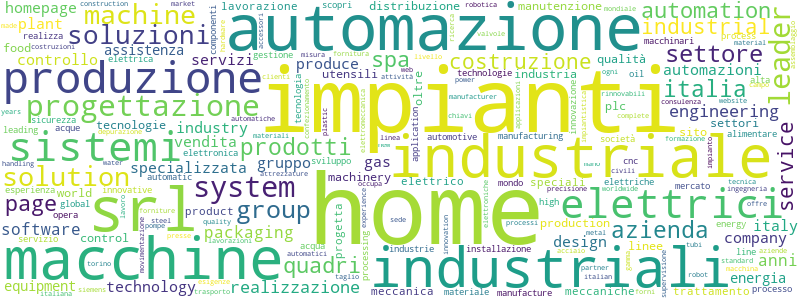

In [102]:
# Clients wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(clientKeywords).to_image()

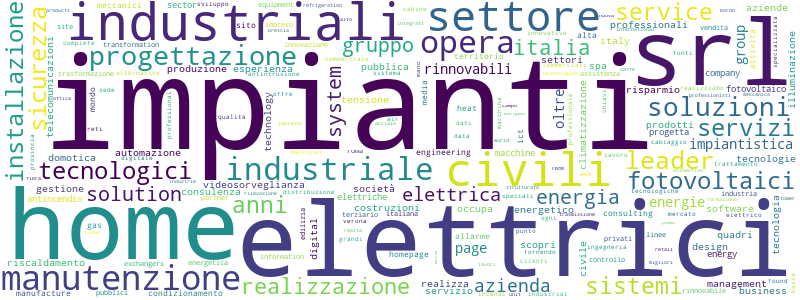

In [103]:
# Prospect wordcloud
wc.WordCloud(background_color="white",
             repeat=False,
             collocations=False,
             width=800,
             height=300).generate(prospectKeywords).to_image()

### La situazione alle code della distribuzione e nel suo centro 

In [104]:
bt.plot_word_frequencies(prospectKeywords, title="Prospect word freq")

In [105]:
bt.plot_word_frequencies(clientKeywords, title="Client word freq")

### Stemming

In [106]:
keywordsNoStem = " ".join(df["Keywords"].tolist())
keywordsNoStem = bt.drop_duplicates(keywordsNoStem).split(" ")
len(keywordsNoStem)

13249

In [107]:
keywordsStem = " ".join(df["Keywords"].tolist())
keywordsStem = bt.stem_words(keywordsStem)
keywordsStem = bt.drop_duplicates(keywordsStem).split(" ")
len(keywordsStem)

9807

In [108]:
df["Keywords"] = df["Keywords"].apply(bt.stem_words)

## Modellazione (Proof of concept)

In [222]:
import importlib

importlib.reload(bt)

<module 'beautifultools' from 'C:\\UserData\\z00400dt\\MarketingPLUS (Giovanna Luisa Grosso)\\Analisi Ateco per Scouting (REPETTO)\\Modello\\beautifultools.py'>

### Step 1: Feauture selection

In [110]:
# Init the document term matrix
cvStep1 = CountVectorizer(binary=True)

X = cvStep1.fit_transform(df["Keywords"])
y = df["Client"].to_numpy()

# Train the marginal screen model with example cutting parameters
margScreen = bt.MarginalScreening(alpha_minus=0.5, alpha_plus=0.5,
                                  kappa=10).fit(X, y)

# Merge words with its values from marginal screening and drop empty words
sentimentCharged = pd.DataFrame(({
    "Word": cvStep1.get_feature_names(),
    "Frequency in Client": margScreen.coef_
}))

sentimentCharged = sentimentCharged.dropna()

The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                            

In [111]:
qgrid.show_grid(sentimentCharged)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Step 2: Topic modelling

In [112]:
df = df.copy()

# Define p-hat as the normalized rank 
df["p hat"] = df["Orders"].rank(pct=True)

# Create a column with only sentiment charged keywords
df["Keywords Filtered"] = df["Keywords"].apply(
    bt.drop_non_sentiment_words,
    sentiment_words=sentimentCharged["Word"].to_list())

# Remove entries without sentiment charged words
df = df[df["Keywords Filtered"] != ""]

# Compute count of sentiment charged words for each webpage
df["s"] = df["Keywords Filtered"].apply(lambda row: len(row.split(" ")))

2020-03-16 09:44:42,030 [11528] WARNING  py.warnings:109: [JupyterRequire] <ipython-input-112-c03c8195a153>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [216]:
test = X[:,:].toarray()

In [221]:
np.sum(test,axis=1).shape

(2956,)

In [113]:
cvStep2 = CountVectorizer()

X = cvStep2.fit_transform(df["Keywords Filtered"])


#y = df["Client"].to_numpy()

In [174]:
s = df["s"].to_numpy()
dS = X.toarray()
tildeD = dS/s[:,None]

In [179]:
tildeD.shape

(2956, 680)

In [182]:
W = np.matrix([df["p hat"], 1-df["p hat"]])
W = W.T

In [185]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(X = W, y = tildeD)

In [188]:
O = reg.coef_

In [193]:
O[O <= 0] = 0

In [196]:
O[:,1]

0.22030259852196304

In [199]:
from sklearn.preprocessing import normalize

normalize(O, norm='l1', axis=0, copy=False, return_norm=False)

array([[0.00548991, 0.        ],
       [0.        , 0.00130656],
       [0.        , 0.00166546],
       ...,
       [0.00192888, 0.        ],
       [0.00121612, 0.        ],
       [0.        , 0.00018963]])

In [203]:
O.shape

(680, 2)

### Step 3: Scoring on webpage

## Conclusioni

In [50]:
# Costruire la matrice d tilde

In [93]:
dHat = np.random.rand(688,df.shape[0])

In [91]:
dHat.shape

(1, 3451)

In [86]:
(W.T*(W * W.T)**-1).shape

(3451, 2)

In [116]:
dHat*(W.T*(W * W.T)**-1)

matrix([[0.48898348, 0.50062819],
        [0.49429792, 0.50083355],
        [0.50321808, 0.50767416],
        ...,
        [0.50629194, 0.48769202],
        [0.49285372, 0.5172801 ],
        [0.48123407, 0.51191041]])

In [97]:
sum(O[:,1])

matrix([[343.79959444]])

In [118]:
from sklearn.linear_model import LinearRegression
X = W
y = dHat
reg = LinearRegression(fit_intercept=False).fit(X.T, y.T)

In [114]:
reg.coef_

array([[0.48898348, 0.50062819],
       [0.49429792, 0.50083355],
       [0.50321808, 0.50767416],
       ...,
       [0.50629194, 0.48769202],
       [0.49285372, 0.5172801 ],
       [0.48123407, 0.51191041]])

In [109]:
X.T.shape

(3451, 2)

In [110]:
y.T.shape

(3451, 688)

In [100]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
dHat*W.T

matrix([[863.90783773, 860.71628293]])

In [115]:
dHat.T * W.T*(W * W.T)**-1

ValueError: shapes (3451,688) and (3451,2) not aligned: 688 (dim 1) != 3451 (dim 0)

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
value = reg.fit(W.T,dHat)

In [ ]:
value.coef_

In [ ]:
 a = np.matrix('0.5 0.3 0.2; 0.5 0.7 0.8')

In [ ]:
a * a.T

In [ ]:
a.shape

In [ ]:
W[:,0:5]